# Imports & Config

In [27]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Path relatif dari folder notebooks/
SPLIT_DIR  = "../data_split"
MODELS_DIR = "../models"
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
EPOCH_HEAD = 2
EPOCH_FINE = 1

os.makedirs(MODELS_DIR, exist_ok=True)
print("Config siap. SPLIT_DIR:", SPLIT_DIR)


Config siap. SPLIT_DIR: ../data_split


# Check data

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(subset, augment=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(SPLIT_DIR, subset),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=(subset=="train")
    )
    ds = ds.map(lambda x,y: (preprocess_input(x), y), AUTOTUNE)
    if augment:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x,y: (aug(x), y), AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = make_dataset("train", augment=True)
val_ds   = make_dataset("val")
test_ds  = make_dataset("test")

print("Batches - train:", train_ds.cardinality().numpy(),
      " val:", val_ds.cardinality().numpy(),
      " test:", test_ds.cardinality().numpy())


✔️  Valid images : 6291
❌  Removed files : 219

List removed:
  - ../data_split\train\adas\adas_134.jpg
  - ../data_split\train\adas\adas_206.jpg
  - ../data_split\train\andaliman\andaliman_202.jpg
  - ../data_split\train\asam jawa\asam-jawa_168.jpg
  - ../data_split\train\asam jawa\asam-jawa_96.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_110.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_117.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_124.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_139.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_150.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_155.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_156.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_157.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_162.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_163.jpg
  - ../data_split\train\bawang bombai\bawang-bombai_164.jpg
  - ../data_split\train\bawang bombai\b

# Cell 2: Load Dataset & Augmentasi

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(subset, augment=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(SPLIT_DIR, subset),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=(subset=="train")
    )
    ds = ds.map(lambda x,y: (preprocess_input(x), y), AUTOTUNE)
    if augment:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x,y: (aug(x), y), AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = make_dataset("train", augment=True)
val_ds   = make_dataset("val")
test_ds  = make_dataset("test")

print("Batches - train:", train_ds.cardinality().numpy(),
      " val:", val_ds.cardinality().numpy(),
      " test:", test_ds.cardinality().numpy())

Found 4373 files belonging to 31 classes.
Found 1255 files belonging to 31 classes.
Found 663 files belonging to 31 classes.
Batches - train: 137  val: 40  test: 21


# Cell 3: Build & Compile Model

In [29]:
base = EfficientNetV2S(include_top=False, weights="imagenet",
                       input_shape=(*IMG_SIZE, 3))
base.trainable = False

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(train_ds.element_spec[1].shape[-1],
                       activation="softmax")(x)

model = Model(base.input, outputs)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print("Model siap. Backbone frozen.")
model.summary()

Model siap. Backbone frozen.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling_4[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 20,371,071 (77.71 MB)

 Trainable params: 39,711 (155.12 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

# Cell 4: Training Head

Epoch 1/2
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3680 - loss: 2.5699

137/137 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.3694 - loss: 2.5651 - val_accuracy: 0.8040 - val_loss: 0.9540
Epoch 2/2
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7971 - loss: 0.9208

137/137 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.7972 - loss: 0.9204 - val_accuracy: 0.8430 - val_loss: 0.6535


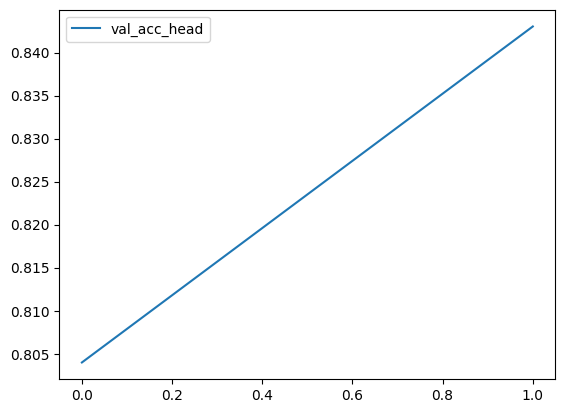

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

ckpt = ModelCheckpoint(os.path.join(MODELS_DIR, "best_model.h5"),
                       save_best_only=True, monitor="val_accuracy")
es   = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCH_HEAD,
                    callbacks=[ckpt, es])

plt.plot(history.history["val_accuracy"], label="val_acc_head")
plt.legend(); plt.show()


# Cell 5: Fine-Tuning

137/137 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.8215 - loss: 0.8303 - val_accuracy: 0.8398 - val_loss: 0.7094


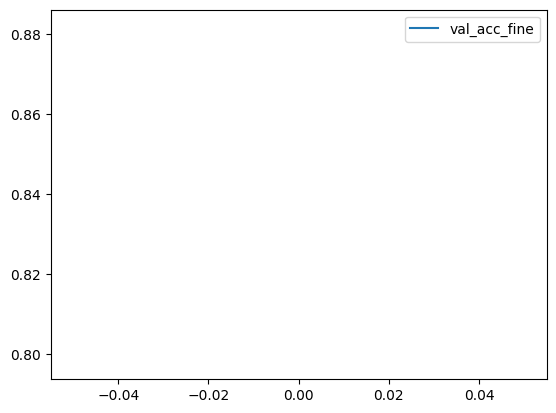

In [31]:
# Unfreeze sebagian backbone
base.trainable = True
for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_f = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCH_FINE,
                      callbacks=[ckpt, es])

plt.plot(history_f.history["val_accuracy"], label="val_acc_fine")
plt.legend(); plt.show()

# Cell 6: Evaluasi Test Set

In [32]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2%}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8483 - loss: 0.6487
Test accuracy: 86.27%
